### <span style="color:red"> Business Challenge </span>
### <span style="color:red">Objectives:</span>
<span style="color:red"> 
•	We would like to determine on an automated basis the accounts that have a high probability of being ‘faked’ accounts    
•	This could be output in a score, a category or both    
•	This would need to take account of the changing patterns    
•	We would want the model to achieve the optimal compliance and financial outcomes 
#### <span style="color:red"> Are there any Machine Learning techniques you think could be used to address this issue? (Please give a brief summary of why the techniques might be most useful)?</span>    

### Solving the <span style="color:red"> Business Challenge </span> 
Machine learning and deep learning techniques could be used to solve this problem. The problem could be considered as a Binary Classification Problem where we would like to predict if an account is Real or Fake one.   
#### Machine learning pipeline to detect fraud/fake accounts 
- The fraud detection team should supply me with a database consists of features/attributes and a Target feature column that determine if a user is fake or real
- The data will be preprocessed to fill/remove any Not Available (NA) data
- Feature engineering will be done and feature importance will be applied to the data to choose the most important features
- The data will be split to train/test samples
- Different machine learning classifiers will be trained using the train sample
- Accuracy of each Classifier will be extracting by using the test sample
- Best model/classifier will be the one that give the highest accuracy and in our case we should pay attention to other metrics such as Recall, precision and f1-score.
- After that, the best model will be used to test new profiles and to predict if they are real or fake.

#### The figure below show a pipeline of the desired technique to detect new profiles (fake or true)

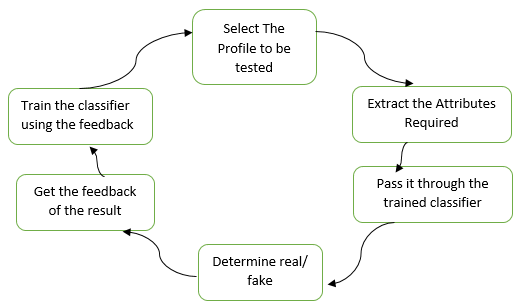

In [117]:
from IPython.core.display import Image, display
display(Image(r'D:\Fake_Profile_Classifying_ML.png', width = 800, height = 800))

================================================================================================================

#### In this notebook, to explain my idea, I am going to solve a similar problem in which fake or real social media accounts will be predicted by using some machine learning classifiers:

## Introduction
This notebook consists of two parts:     
1- Classifying Social Media Fake Accounts using predictive modeling  
2- Report   

## 1- Classifying Fake Accounts using predictive modeling
The problem of classifying how to discover fake accounts will be studied. Python scikit-learn machine learning package is used and 3 different classification models will be tested:    
1- Logistic Regression       
2- Decision Tree      
3- Random Forest   
   

### Functions
The following functions were created to read, discover, splitting into training/testing sets, modeling and predicting data, and visualizing results. 

In [1]:
# importing required packages
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams.update({'font.size': 14})
import gender_guesser.detector as gender

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")

# 1
def importing_data(path):
    ''' Reads users profile from csv files '''
    df = pd.read_csv(path)
    return df

# # 2
# def discovering_data(df):
#     ''' discovering data '''
#     print(62 * '=')
#     print('data head\n', df.head(), '\n')
#     print(62 * '=')
#     #print('data tail\n', df.tail(), '\n')
#     #print(62 * '=')
#     print('data description\n', df.groupby('stroke').describe(), '\n')
#     print(62 * '=')

# 3
def predict_gender(df):
    gender_predictor = gender.Detector(case_sensitive=False)
    first_name = df['name'].str.split(' ').str.get(0)
    gend = first_name.apply(gender_predictor.get_gender)
    gender_dict = {'female': -2, 'mostly_female': -1,'unknown':0,'mostly_male':1, 'male': 2}
    gender_code = gend.map(gender_dict).astype('category')
    df['name'] = gender_code
    df.dropna(inplace=True)
    return df

# 4
def trn_tst_split(df, test_size = 0.2, random_state = 2020):
    '''splitting data into training and testing sets '''
    df_ = df.copy()
    X, y = df_.loc[:,~df_.columns.isin(['target'])], df_['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)
    return X_train, X_test, y_train, y_test

# 5
def classifiers(class_weight = None):
    ''' defining the models that will be used in classification, class_weight = None or 'balanced' '''
    rs = 2020
    clsf = []
    clsf.append(('LR', LogisticRegression(class_weight = class_weight, random_state = rs)))
    clsf.append(('DT', DecisionTreeClassifier(class_weight = class_weight, random_state = rs)))
    clsf.append(('RF', RandomForestClassifier(class_weight = class_weight, random_state = rs)))
    return dict(clsf)

# 6
def train_classifier(clsf, X_train, y_train): 
    '''training a classifier to fit a trained set'''
    model = clsf.fit(X_train, y_train)
    return model 

# 7
def predict_labels(model, X_test):
    '''using the classifier to predict labels of test set'''
    y_pred = model.predict(X_test)
    return y_pred  

# 8
def accuracy_confusion(clsf, X_train, y_train, X_test, y_test):
    ''' getting accuracy for each model and predicted labels and the confusion matrix '''
    clsf_key = []
    scores = []
    #df_pred = []
    target_names = ['0', '1']  
    for key, value in clsf.items():
        model = train_classifier(value, X_train, y_train)     # training classifier by using the training set
        y_pred = predict_labels(model, X_test)     # testing the classifier by using test set
        #print(X_test.shape, y_pred.shape, y_test.shape)
        cnf_matrix = confusion_matrix(y_test, y_pred)    # getting the confusion matrix
        print(' Model: ' + key, '\n', classification_report(y_test, y_pred, target_names = target_names), '\n')
        clsf_key.append(key)
        scores.append(accuracy_score(y_test, y_pred))  # calculating Accuracy of each model        
        print('\n', 'Accuracy of the ' + '"' + key + '"' + ' model = ', round(accuracy_score(y_test, y_pred) * 100, 2), '%', '\n' )
        plot_confusion_matrix(key, y_test, y_pred, target_names, True)   
        print(60 * '=')
    df_scores = pd.DataFrame({'Classifier': clsf_key, 'Score': scores})
    return df_scores.sort_values(by = 'Score', ascending = False).reset_index(drop = True)

# 9
def random_over_sampling(X_train, y_train):
    ''' performing random over sampling to convert imbalanced data into balanced '''
    ros = RandomOverSampler(random_state = 2020)
    X_ros, y_ros = ros.fit_resample(X_train, y_train)
    print('ros shape for features) :   {}'.format(X_ros.shape))
    print('ros shape for labels) :   {}'.format(y_ros.shape))
    return X_ros, y_ros

# 10
def plot_confusion_matrix(k, y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes  #[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('normalized confusion matrix of the ' + '"' + k + '"' + ' model ' )
    else:
        print('confusion matrix of the ' + '"' + k + '"' + ' model ')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

#%% 

Using TensorFlow backend.


In [84]:
#print module versions for reproducibility
import matplotlib
import imblearn
print('Numby version {}'.format(np.__version__))
print('Pandas version {}'.format(pd.__version__))
print('Matplotlib version {}'.format(matplotlib.__version__))
print('PandasProfiling version {}'.format(pandas_profiling.__version__))
print('Sklearn version {}'.format(sklearn.__version__))
print('Imblearn version {}'.format(imblearn.__version__))

Numby version 1.16.5
Pandas version 0.25.1
Matplotlib version 3.1.1
PandasProfiling version 2.3.0
Sklearn version 0.21.3
Imblearn version 0.5.0


In [ ]:
path = r'C:\data.csv'  
df = importing_data(path)               # importing data as a pandas dataframe

### Exploring the data
Instead of using Pandas package to explore the data, I will use **Pandas Profiling** package which is a great package that could be used to analyze the data and to get an overview about variables, data types, missing values and visualizing the data. In only one line of code you will have the data analyzed, please see the **full_report** below:

In [ ]:
full_report = pandas_profiling.ProfileReport(df)   # data exploring full report

In [102]:
full_report


The main aim of this work is to predict the fake accounts, **['target'] label where '0' means Real account and '1' means Fake account**, by using all or some of the features above, i.e, ['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'lang_code', 'name'].
From the **full_report** I noticed that:
- The data is imbalanced because 94.8% of the accounts are genuine and 5.2% accounts are fake. So, the problem that we are going to solve need to be handled carefully before using machine learning to build the predictive model. I will use class_weight = 'balance', where the class weights for imbalanced classes of the dataset will be estimated       
Details are given below:

### Train_test split the dataset
The function **trn_tst_split** is used to split the dataset (**df**) into train (80%) and test (20%) samples:

In [103]:
X_train, X_test, y_train, y_test = trn_tst_split(df)

In [115]:
print(' Shape of training featurs ', X_train.shape)
print(' Shape of training label ', y_train.shape)
print(' Shape of test sample ', X_test.shape)
print(' Shape of test label ', y_test.shape)

 Shape of training featurs  (2213, 7)
 Shape of training label  (2213,)
 Shape of test sample  (554, 7)
 Shape of test label  (554,)


### Classifiers
We are going to use these classification models through this work:

In [122]:
clsf_balanced = classifiers(class_weight = 'balanced')  # using 'classifiers' function to create a balanced dataset

In [106]:
print("The used classifiers are: ", [k for k in clsf.keys()])

The used classifiers are:  ['LR', 'DT', 'RF']


### Predictive models
The classifiers (**clsf_balanced**) are used to train classification models on the train set then the model will be used to validate the data by using the test set. Accuracies of the models and confusion matrix are extracted and visualized. The **accuracy_confusion** function is used to do all of that: 

## 2 - Report
I will give some comments on the results obtained and its discussion: 

### Balanced Data (class_weight = 'balanced')

 Model: LR 
               precision    recall  f1-score   support

           0       0.99      0.57      0.73       530
           1       0.09      0.88      0.15        24

    accuracy                           0.59       554
   macro avg       0.54      0.72      0.44       554
weighted avg       0.95      0.59      0.70       554
 


 Accuracy of the "LR" model =  58.66 % 

normalized confusion matrix of the "LR" model 
[[0.57358491 0.42641509]
 [0.125      0.875     ]]


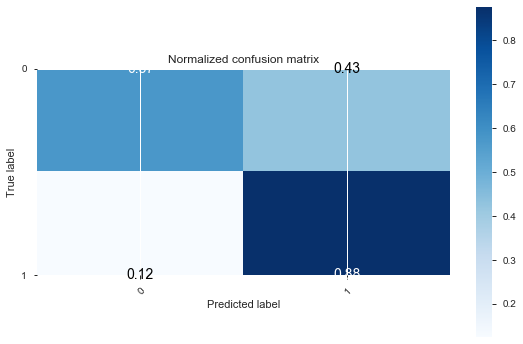

 Model: DT 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       530
           1       0.25      0.25      0.25        24

    accuracy                           0.94       554
   macro avg       0.61      0.61      0.61       554
weighted avg       0.94      0.94      0.94       554
 


 Accuracy of the "DT" model =  93.5 % 

normalized confusion matrix of the "DT" model 
[[0.96603774 0.03396226]
 [0.75       0.25      ]]


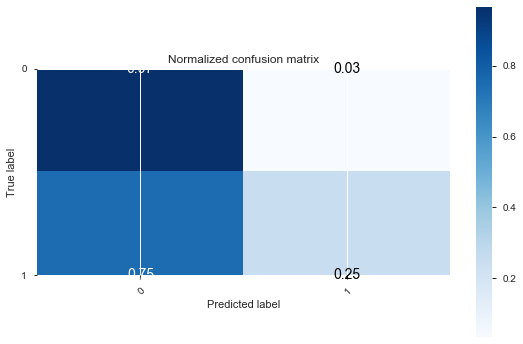

 Model: RF 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       530
           1       0.00      0.00      0.00        24

    accuracy                           0.95       554
   macro avg       0.48      0.50      0.49       554
weighted avg       0.92      0.95      0.93       554
 


 Accuracy of the "RF" model =  95.13 % 

normalized confusion matrix of the "RF" model 
[[0.99433962 0.00566038]
 [1.         0.        ]]


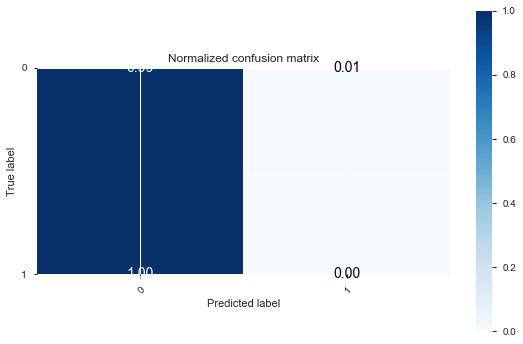

In [109]:
df_scores_balanced = accuracy_confusion(clsf_balanced, X_train, y_train, X_test, y_test) # using class_weight = 'balanced'

In [110]:
df_scores_balanced  # print the accuracy of each classifier 

,Classifier,Score
0,RF,0.951264
1,DT,0.935018
2,LR,0.586643


### Comments on the results
Among the 3 classifiers used, the Random Forest Classifier (RF)  has the highest accuracy (95.13%) of predicting fake accounts, then the Decision Tree (DT) with approximately (93.50%). The Linear Regression Classifier (LR) has prediction accuracy of (58.67%).

### Feature importance
Here, I will use the random forest classifier to get the features importance of the data:

                  feature_importance
friends_count               0.230224
statuses_count              0.218845
followers_count             0.179698
favourites_count            0.176620
lang_code                   0.102742
listed_count                0.053600
name                        0.038270


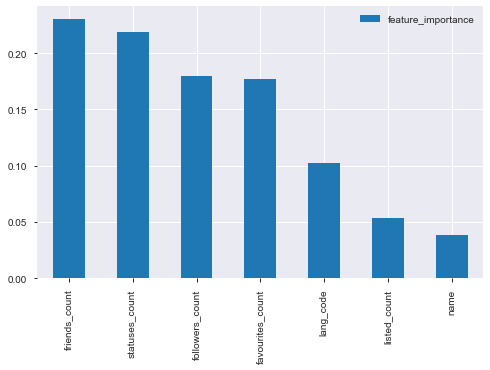

In [116]:
rfc_model = RandomForestClassifier(random_state = 2020)
rfc_model.fit(X_ros_train, y_ros_train)
features_importance = pd.DataFrame(rfc_model.feature_importances_, index = X_train.columns, columns=['feature_importance']).sort_values(by ='feature_importance', ascending = False)
print(features_importance)
features_importance.plot(kind='bar')

It is clear that the most important features are **'followers_count', 'friends_count', 'favourites_count' and 'statuses_count'**.

### - Conclusion
Classification of fake accounts is an interesting problems of machine learning on bet and gambling industry. Many researchers/data scientists around the world attempted to solve it and then there are many approaches to deal with that problem. In this approach, a python code was created to read the fake accounts database. Then, the data was explored by using pandas profiling model. Before building a classification model, the data were split into two sets: training set consists of 80% of the whole sample and test set which has the rest of data. The fake accounts data consists of 7 features, and one target ['target']. The main aim is to use the training data to train a model to fit the trained features with the trained labels, then the model will be used to predict labels of given features from the test set. Then, the predicted labels will be compared to the real ones and the accuracy of the model will be calculated.The higher the accuracy means the best performance of the model. On modeling step, since I have no preferred approach to any model, I used 3 machine learning models to classify the data. To choose the best model among them, the accuracy of each model was calculated and the results were sorted according to the accuracy values. Meanwhile, the confusion matrix was calculated and shown to visualize the accuracy of the model. In general, the best model among others is the Random Forest Classifier (RF), its accuracy = 95.13%. Then, I recommend to use RF in classifying the fake accounts data.

Thank you for your time!